In [989]:
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime  
from nltk.tokenize import word_tokenize  
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind


import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer

# function to make n-grams
from nltk.util import ngrams 

from gensim.corpora import Dictionary
import itertools
from collections import defaultdict
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

In [945]:
df = pd.read_csv('../data/processed/cleaned_data_2.csv')
# increasing max length for all columns and rows
pd.set_option('display.max_colwidth', -1)

pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 500)

In [946]:
# functions for tokenizing, word count and wordcloud
tknz = TweetTokenizer()
whts = WhitespaceTokenizer()
def tokenize_whitespace(s):
    """
    Tokenize each text into a list of words leaving the ashtags
    """
    tokens = whts.tokenize(s)
    return [w for w in tokens]


def tokenize_tweet(s):
    """
    Tokenize each text into a list of words removing the ashtags
    """
    tokens = tknz.tokenize(s)
    return [w for w in tokens]


def get_tokens_frequency_df(series):
    """
    Count each time the same word appeared in the series
    :return: dataFrame
    """
    corpus_lists = [doc for doc in series.dropna() if doc]
    dictionary = Dictionary(corpus_lists)
    corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_lists]
    token_freq_bow = defaultdict(int)
    for token_id, token_sum in itertools.chain.from_iterable(corpus_bow):
        token_freq_bow[token_id] += token_sum

    return pd.DataFrame(list(token_freq_bow.items()), columns=['token_id', 'token_count']).assign(
        token=lambda df1: df1.apply(lambda df2: dictionary.get(df2.token_id), axis=1),
        doc_appeared=lambda df1: df1.apply(lambda df2: dictionary.dfs[df2.token_id], axis=1)).reindex(
        labels=['token_id', 'token', 'token_count', 'doc_appeared'], axis=1).set_index('token_id')


def plot_word_cloud(df, top_n):
    word_cloud = WordCloud(background_color='white', colormap='magma', contour_width=1,
                           contour_color='orange', relative_scaling=0.5)

    sorted_freq_dict = dict(df[['token', 'token_count']].nlargest(top_n, columns='token_count').values)
    wc = word_cloud.generate_from_frequencies(frequencies=sorted_freq_dict, max_font_size=40)

    _, ax = plt.subplots(figsize=(15, 8))
    ax.set_title('Term Frequency', fontsize=16)

    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')

    

In [947]:
# for some reason we keep having missing values....
df.isna().sum()

tweet_low                          0 
handle_count                       0 
no_handle_no_special_no_sin_ash    0 
tweet_length                       0 
character_count                    0 
lemmatized                         3 
lemmatized_1                       3 
lemmatized_final                   3 
tweet_without_stopwords            26
tweet_without_stopwords_and_2      39
pos_label                          0 
dtype: int64

In [948]:
len(df)

42031

In [949]:
# not very useful as most of these were filled with either handles or only emoticons
nan_values = df.loc[df['tweet_without_stopwords_and_2'].isna()]
nan_values.head(5)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,pos_label
385,what i doð,0,what i do,14,7,what i do,what i do,what i do,NaN,NaN,1
566,@user it's at $7.25,1,it's at,16,6,it 's at,it 's at,it's at,'s,NaN,1
1549,@user @user @user @user @user @user @user @user @user @user,10,,10,0,NaN,NaN,NaN,NaN,NaN,1
2878,it was in 2008,0,it was in,15,7,it be in,it be in,it be in,NaN,NaN,1
2984,@user then why are you,1,then why are you,19,13,then why be you,then why be you,then why be you,NaN,NaN,1


In [950]:
# filtering to have non-missing values
df = df.loc[df['tweet_without_stopwords_and_2'].notnull()]

In [951]:
df.isna().sum()

tweet_low                          0
handle_count                       0
no_handle_no_special_no_sin_ash    0
tweet_length                       0
character_count                    0
lemmatized                         0
lemmatized_1                       0
lemmatized_final                   0
tweet_without_stopwords            0
tweet_without_stopwords_and_2      0
pos_label                          0
dtype: int64

In [952]:
df.head(5)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,pos_label
0,13 days to go #gettingthere,0,days to go #gettingthere,30,21,day to go # gettingthere,day to go #gettingthere,day to go # gettingthere,day go # gettingthere,day gettingthere,1
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,0
2,these hoes got more bodies than a cemetery&#128056;&#9749;&#65039;.,0,these hoes got more bodies than a cemetery,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,0
3,a friend just told me she's afraid to go to dc rally &amp; be attacked by #berniebros or the @user racists cuz she's not white.,1,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,124,95,a friend just tell me she 's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she 's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,a friend just tell me she's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she's not white,friend tell 's afraid go dc rally amp attack # berniebros racist cuz 's white,friend tell afraid rally amp attack berniebros racist cuz white,1
4,i've noticed a lot of #icontf16 presentations mention happiness. wonder if profession has above average happiness? @user,1,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,117,95,i 've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,i've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot # icontf presentation mention happiness wonder profession average happiness,'ve notice lot icontf presentation mention happiness wonder profession average happiness,1


# Dividing into positive and negative dfs

In [953]:
# dividing into positive and negative dfs
df_pos = df.loc[df['pos_label'] == 1]

In [954]:
len(df_pos)

21383

In [955]:
df_neg = df.loc[df['pos_label'] == 0]

In [956]:
len(df_neg)

20609

# Tokenization

### Positive DF

Making a few final changes to the very final column which is tweet without stopwords and with words at least 3 character long.
Ashtags are mixed with the words. We'll perform a separate analysis to look at only ashtags. In this instance we want to transform negation partcicles n't into 'not' and get rid of single apotrophes that were left there by lemmatization.

In [957]:
# replacing n't with not
df_pos['tweet_without_stopwords_and_2'] = df_pos['tweet_without_stopwords_and_2'].str.replace("n't", "not")


In [958]:
# getting rid of single apostrophes
df_pos['tweet_without_stopwords_and_2'] = df_pos['tweet_without_stopwords_and_2'].str.replace(" '", "")
df_pos['tweet_without_stopwords_and_2'] = df_pos['tweet_without_stopwords_and_2'].str.replace("' ", "")
 
df_pos.head(25)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,pos_label
0,13 days to go #gettingthere,0,days to go #gettingthere,30,21,day to go # gettingthere,day to go #gettingthere,day to go # gettingthere,day go # gettingthere,day gettingthere,1
3,a friend just told me she's afraid to go to dc rally &amp; be attacked by #berniebros or the @user racists cuz she's not white.,1,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,124,95,a friend just tell me she 's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she 's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,a friend just tell me she's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she's not white,friend tell 's afraid go dc rally amp attack # berniebros racist cuz 's white,friend tell afraid rally amp attack berniebros racist cuz white,1
4,i've noticed a lot of #icontf16 presentations mention happiness. wonder if profession has above average happiness? @user,1,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,117,95,i 've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,i've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot # icontf presentation mention happiness wonder profession average happiness,'ve notice lot icontf presentation mention happiness wonder profession average happiness,1
5,getting for this weekends shows! #country #music #lylepierce,0,getting for this weekends shows #country #music #lylepierce,62,52,get for this weekend show # country # music # lylepierce,get for this weekend show #country #music #lylepierce,get for this weekend show # country # music # lylepierce,get weekend show # country # music # lylepierce,get weekend show country music lylepierce,1
6,@user my final legislative session day has officially begun! @user @user #albany,3,my final legislative session day has officially begun #albany,69,53,my final legislative session day have officially begin # albany,my final legislative session day have officially begin #albany,my final legislative session day have officially begin # albany,final legislative session day officially begin # albany,final legislative session day officially begin albany,1
8,a #bikini kind of life ð´ summer #palmtrees #breeze #place #cali #california #swimwearâ¦,0,a #bikini kind of life summer #palmtrees #breeze #place #cali #california #swimwear,96,72,a # bikini kind of life summer # palmtrees # breeze # place # cali # california # swimwear,a #bikini kind of life summer #palmtrees #breeze #place #cali #california #swimwear,a # bikini kind of life summer # palmtrees # breeze # place # cali # california # swimwear,# bikini kind life summer # palmtrees # breeze # place # cali # california # swimwear,bikini kind life summer palmtrees breeze place cali california swimwear,1
9,"very sad people with very sad lives, gossiping about people who are fuck all to do with them #getalife",0,very sad people with very sad lives gossiping about people who are fuck all to do with them #getalife,104,83,very sad people with very sad life gossip about people who be fuck all to do with them # getalife,very sad people with very sad life gossip about people who be fuck all to do with them #getalife,very sad people with very sad life gossip about people who be fuck all to do with them # getalife,sad people sad life gossip people fuck # getalife,sad people sad life gossip people fuck getalife,1
11,missy elliot for marc jacobs is supa dupa fl

In [959]:
# make new columns for positives with a list of words 
df_pos['tweet_low_tok'] = df_pos[df_pos ['tweet_low'].notna()]['tweet_low'].apply(tokenize_tweet)
df_pos['lemmatized_1_tok'] = df_pos[df_pos ['lemmatized_1'].notna()]['lemmatized_1'].apply(tokenize_tweet)
df_pos['lemmatized_final_tok'] = df_pos[df_pos ['lemmatized_final'].notna()]['lemmatized_final'].apply(tokenize_tweet)
df_pos['tweet_without_stopwords_and_2_tok'] = df_pos[df_pos ['tweet_without_stopwords_and_2'].notna()]['tweet_without_stopwords_and_2'].apply(tokenize_tweet)


In [960]:
df_pos.head(10)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,pos_label,tweet_low_tok,lemmatized_1_tok,lemmatized_final_tok,tweet_without_stopwords_and_2_tok
0,13 days to go #gettingthere,0,days to go #gettingthere,30,21,day to go # gettingthere,day to go #gettingthere,day to go # gettingthere,day go # gettingthere,day gettingthere,1,"[13, days, to, go, #gettingthere]","[day, to, go, #gettingthere]","[day, to, go, #, gettingthere]","[day, gettingthere]"
3,a friend just told me she's afraid to go to dc rally &amp; be attacked by #berniebros or the @user racists cuz she's not white.,1,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,124,95,a friend just tell me she 's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she 's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,a friend just tell me she's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she's not white,friend tell 's afraid go dc rally amp attack # berniebros racist cuz 's white,friend tell afraid rally amp attack berniebros racist cuz white,1,"[a, friend, just, told, me, she's, afraid, to, go, to, dc, rally, &, be, attacked, by, #berniebros, or, the, @user, racists, cuz, she's, not, white, .]","[a, friend, just, tell, me, she, ', s, afraid, to, go, to, dc, rally, amp, be, attack, by, #berniebros, or, the, racist, cuz, she, ', s, not, white]","[a, friend, just, tell, me, she's, afraid, to, go, to, dc, rally, amp, be, attack, by, #, berniebros, or, the, racist, cuz, she's, not, white]","[friend, tell, afraid, rally, amp, attack, berniebros, racist, cuz, white]"
4,i've noticed a lot of #icontf16 presentations mention happiness. wonder if profession has above average happiness? @user,1,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,117,95,i 've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,i've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot # icontf presentation mention happiness wonder profession average happiness,'ve notice lot icontf presentation mention happiness wonder profession average happiness,1,"[i've, noticed, a, lot, of, #icontf16, presentations, mention, happiness, ., wonder, if, profession, has, above, average, happiness, ?, @user]","[i, ', ve, notice, a, lot, of, #icontf, presentation, mention, happiness, wonder, if, profession, have, above, average, happiness]","[i've, notice, a, lot, of, #, icontf, presentation, mention, happiness, wonder, if, profession, have, above, average, happiness]","[', ve, notice, lot, icontf, presentation, mention, happiness, wonder, profession, average, happiness]"
5,getting for this weekends shows! #country #music #lylepierce,0,getting for this weekends shows #country #music #lylepierce,62,52,get for this weekend show # country # music # lylepierce,get for this weekend show #country #music #lylepierce,get for this weekend show # country # music # lylepierce,get weekend show # country # music # lylepierce,get weekend show country music lylepierce,1,"[getting, for, this, weekends, shows, !, #country, #music, #lylepierce]","[get, for, this, weekend, show, #country, #music, #lylepierce]","[get, for, this, weekend, show, #, country, #, music, #, lylepierce]","[get, weekend, show, country, music, lylepierce]"
6,@user my final legislative session day has officially begun! @user @user #albany,3,my final legislative session day has officially begun #albany,69,53,my final legislative session day have officially begin # albany

Inserting into a dataframe overall count of words for positive

In [961]:
tokens_pos = get_tokens_frequency_df(df_pos['tweet_without_stopwords_and_2_tok'])

In [962]:
tokens_pos = tokens_pos.sort_values(by='token_count', ascending = False)
tokens_pos.head(10)


,token,token_count,doc_appeared
token_id,,,
0,day,2113,1944
125,love,1964,1819
121,not,1607,1501
24,get,1327,1273
228,happy,1250,1183
3,amp,1101,984
40,life,923,851
267,make,842,804
138,today,825,817


### Negative DF

Removing apostrophes and n't as we did for postive words first

In [963]:
df_neg

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,pos_label
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,0
2,these hoes got more bodies than a cemetery&#128056;&#9749;&#65039;.,0,these hoes got more bodies than a cemetery,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,0
7,@lucas_wright955 @michaelgt03 faggots,2,faggots,9,7,faggot,faggot,faggot,faggot,faggot,0
10,"@hoponthebeast i found her right here, good job unfollowing me btw faggot http://t.co/kd3iseiold",1,i found her right here good job unfollowing me btw faggot,60,47,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot,find right good job unfollowing btw faggot,0
14,"technology ain't doin nothing, but making these hoes look better",0,technology ain't doin nothing but making these hoes look better,64,54,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing make hoe look good,technology n't doin nothing make hoe look good,0
...,...,...,...,...,...,...,...,...,...,...,...
42024,"rt @makeup_sex: trash talked by many . hated by some . & guess how many fucks i give , its less than one .",1,rt trash talked by many hated by some guess how many fucks i give its less than one,95,66,rt trash talk by many hat by some guess how many fuck i give its less than one,rt trash talk by many hat by some guess how many fuck i give its less than one,rt trash talk by many hat by some guess how many fuck i give its less than one,rt trash talk many hat guess many fuck give less one,trash talk many hat guess many fuck give less one,0
42026,@_elenaraquel_ its swag bitch aha,1,its swag bitch aha,19,15,its swag bitch aha,its swag bitch aha,its swag bitch aha,swag bitch aha,swag bitch aha,0
42028,rt @_groovymovie: &#8220;@shane_a1: hmu talmbout match but when i pull up its 30 other niccas wit ya &#128530;&#8221; smfh shit like that kill me,2,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,114,73,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match pull niccas wit ya smfh shit like kill,hmu talmbout match pull niccas wit smfh shit like kill,0
42029,rt @obey_jrock__: this is a true ride or die bitch &#128175; http://t.co/y1t8ctqn4u,1,rt this is a true ride or die bitch,45,27,rt this be a true ride or die bitch,rt this be a true ride or die bitch,rt this be a true ride or die bitch,rt true ride die bitch,true ride die bitch,0


In [964]:
# replacing n't with not
df_neg['tweet_without_stopwords_and_2'] = df_neg['tweet_without_stopwords_and_2'].str.replace("n't", "not")
df_neg.head(5)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,pos_label
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,0
2,these hoes got more bodies than a cemetery&#128056;&#9749;&#65039;.,0,these hoes got more bodies than a cemetery,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,0
7,@lucas_wright955 @michaelgt03 faggots,2,faggots,9,7,faggot,faggot,faggot,faggot,faggot,0
10,"@hoponthebeast i found her right here, good job unfollowing me btw faggot http://t.co/kd3iseiold",1,i found her right here good job unfollowing me btw faggot,60,47,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot,find right good job unfollowing btw faggot,0
14,"technology ain't doin nothing, but making these hoes look better",0,technology ain't doin nothing but making these hoes look better,64,54,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing make hoe look good,technology not doin nothing make hoe look good,0


In [965]:
# replacing 'n t' with not
df_neg['tweet_without_stopwords_and_2'] = df_neg['tweet_without_stopwords_and_2'].str.replace("n t", "not")
df_neg.head(5)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,pos_label
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,0
2,these hoes got more bodies than a cemetery&#128056;&#9749;&#65039;.,0,these hoes got more bodies than a cemetery,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,0
7,@lucas_wright955 @michaelgt03 faggots,2,faggots,9,7,faggot,faggot,faggot,faggot,faggot,0
10,"@hoponthebeast i found her right here, good job unfollowing me btw faggot http://t.co/kd3iseiold",1,i found her right here good job unfollowing me btw faggot,60,47,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot,find right good job unfollowing btw faggot,0
14,"technology ain't doin nothing, but making these hoes look better",0,technology ain't doin nothing but making these hoes look better,64,54,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing make hoe look good,technology not doin nothing make hoe look good,0


In [966]:
# getting rid of single apostrophes
df_neg['tweet_without_stopwords_and_2'] = df_neg['tweet_without_stopwords_and_2'].str.replace(" '", "")
df_neg['tweet_without_stopwords_and_2'] = df_neg['tweet_without_stopwords_and_2'].str.replace("' ", "")

In [967]:
# make new columns for negatives with a list of words 
df_neg['tweet_low_tok'] = df_neg[df_neg ['tweet_low'].notna()]['tweet_low'].apply(tokenize_tweet)
df_neg['lemmatized_1_tok'] = df_neg[df_neg ['lemmatized_1'].notna()]['lemmatized_1'].apply(tokenize_tweet)
df_neg['lemmatized_final_tok'] = df_neg[df_neg ['lemmatized_final'].notna()]['lemmatized_final'].apply(tokenize_tweet)
df_neg['tweet_without_stopwords_and_2_tok'] = df_neg[df_neg['tweet_without_stopwords_and_2'].notna()]['tweet_without_stopwords_and_2'].apply(tokenize_tweet)

In [968]:
df_neg.head(10)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,pos_label,tweet_low_tok,lemmatized_1_tok,lemmatized_final_tok,tweet_without_stopwords_and_2_tok
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,0,"[@anggxo, get, off, my, twitter, fag]","[get, off, my, twitter, fag]","[get, off, my, twitter, fag]","[get, twitter, fag]"
2,these hoes got more bodies than a cemetery&#128056;&#9749;&#65039;.,0,these hoes got more bodies than a cemetery,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,0,"[these, hoes, got, more, bodies, than, a, cemetery, 🐸, ☕, ️, .]","[these, hoe, get, more, body, than, a, cemetery]","[these, hoe, get, more, body, than, a, cemetery]","[hoe, get, body, cemetery]"
7,@lucas_wright955 @michaelgt03 faggots,2,faggots,9,7,faggot,faggot,faggot,faggot,faggot,0,"[@lucas_wright955, @michaelgt03, faggots]",[faggot],[faggot],[faggot]
10,"@hoponthebeast i found her right here, good job unfollowing me btw faggot http://t.co/kd3iseiold",1,i found her right here good job unfollowing me btw faggot,60,47,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot,find right good job unfollowing btw faggot,0,"[@hoponthebeast, i, found, her, right, here, ,, good, job, unfollowing, me, btw, faggot, http://t.co/kd3iseiold]","[i, find, her, right, here, good, job, unfollowing, me, btw, faggot]","[i, find, her, right, here, good, job, unfollowing, me, btw, faggot]","[find, right, good, job, unfollowing, btw, faggot]"
14,"technology ain't doin nothing, but making these hoes look better",0,technology ain't doin nothing but making these hoes look better,64,54,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing make hoe look good,technology not doin nothing make hoe look good,0,"[technology, ain't, doin, nothing, ,, but, making, these, hoes, look, better]","[technology, ai, n't, doin, nothing, but, make, these, hoe, look, good]","[technology, ai, n't, doin, nothing, but, make, these, hoe, look, good]","[technology, not, doin, nothing, make, hoe, look, good]"
15,&#8220;@ciddyp_60: i wouldn't trust a male cheerleader @ all cuz .&#8221; cimarron got one &#128514; &amp; he got allll the bitches,2,i wouldn't trust a male cheerleader all cuz cimarron got one amp he got allll the bitches,111,73,i would n't trust a male cheerleader all cuz cimarron get one amp he get allll the bitch,i would n't trust a male cheerleader all cuz cimarron get one amp he get allll the bitch,i would n't trust a male cheerleader all cuz cimarron get one amp he get allll the bitch,would n't trust male cheerleader cuz cimarron get one amp get allll bitch,would not trust male cheerleader cuz cimarron get one amp get allll bitch,0,"[“, @ciddyp_60, :, i, wouldn't, trust, a, male, cheerleader, @, all, cuz, ., ”, cimarron, got, one, 😂, &, he, got, allll, the, bitches]","[i, would, n't, trust, a, male, cheerleader, all, cuz, cimarron, get, one, amp, he, get, allll, the, bitch]","[i, would, n't, trust, a, male, cheerleader, all, cuz, cimarron, get, one, amp, he, get, allll, the, bitch]","[would, not, trust, male, cheerleader, cuz, cimarron, get, one, amp, get, allll, bitch]"
17,@liveitupjersey @d_cassandra_d @bad_boy_six lol! that was a cyber bitch slap for sure!,3,lol that was a cyber bitch slap for sure,45,32,lol that be a cyber bitch slap for sure,lol that be a cyber bitch slap for sure,lol that be a cyber bitch

In [969]:
tokens_neg = get_tokens_frequency_df(df_neg['tweet_without_stopwords_and_2_tok'])

In [970]:
tokens_neg = tokens_neg.sort_values(by = 'token_count', ascending = False)
tokens_neg.head(10)

,token,token_count,doc_appeared
token_id,,,
21,bitch,11373,10642
5,hoe,4267,3957
16,not,3334,3017
1,get,3020,2764
121,like,2525,2304
36,pussy,2244,2144
42,fuck,2038,1880
35,nigga,1720,1549
153,ass,1589,1476


# Graphs most Recurring negative and positive words both ashtags and normal lexicon

## Plot top 10 positive words (both ashtags and standard lexicon)

Text(0.5, 1.0, 'Most common positive words')

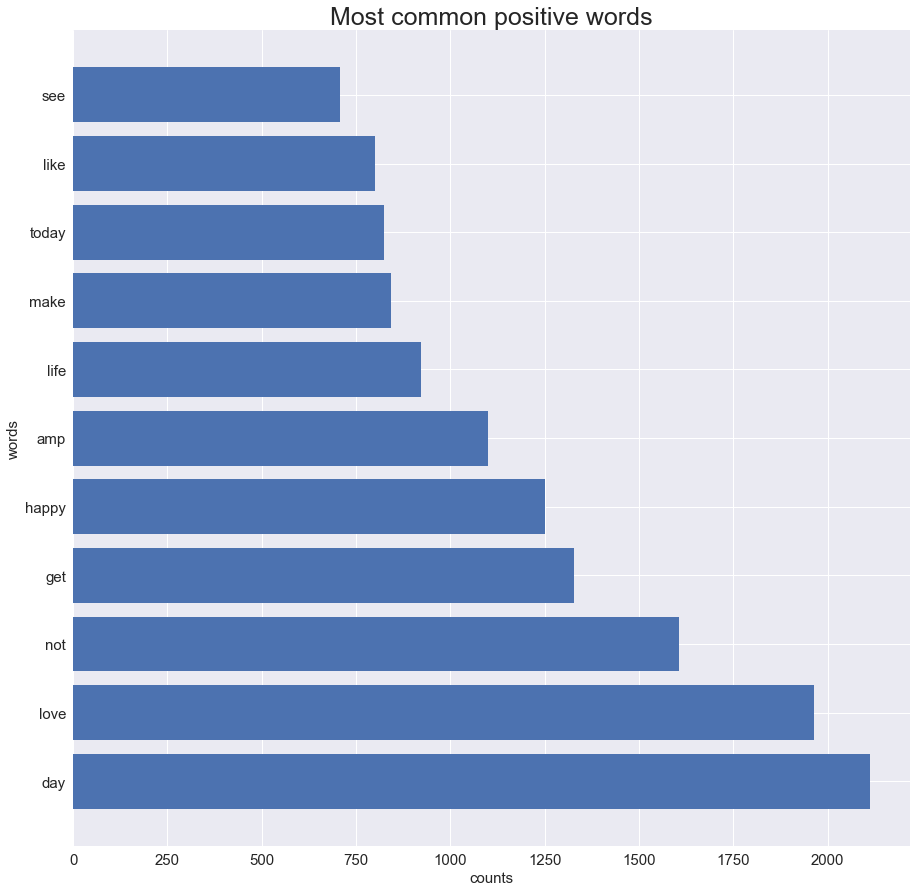

In [971]:
top_10_pos = tokens_pos[:11]

fig, ax = plt.subplots(figsize = (15,15))

plt.style.use('seaborn')
ax.barh(top_10_pos['token'], top_10_pos['token_count'])
plt.xlabel('counts', fontsize=15)
plt.ylabel('words',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Most common positive words', fontsize=25)

# fig.savefig('yourfilename.png')

## WordCloud Positive words (both ashtags and standard lexicon)

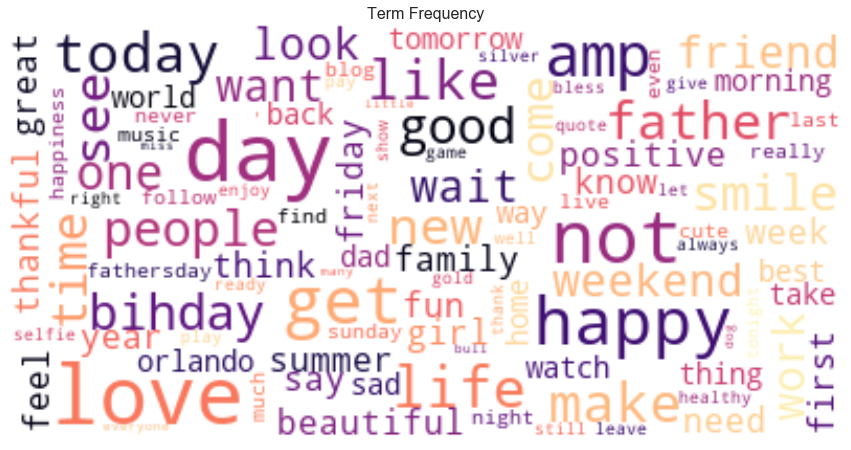

In [972]:
plot_word_cloud(tokens_pos,100)

## Plot top 10 negative words (both ashtags and standard lexicon)

Text(0.5, 1.0, 'Most common negative words')

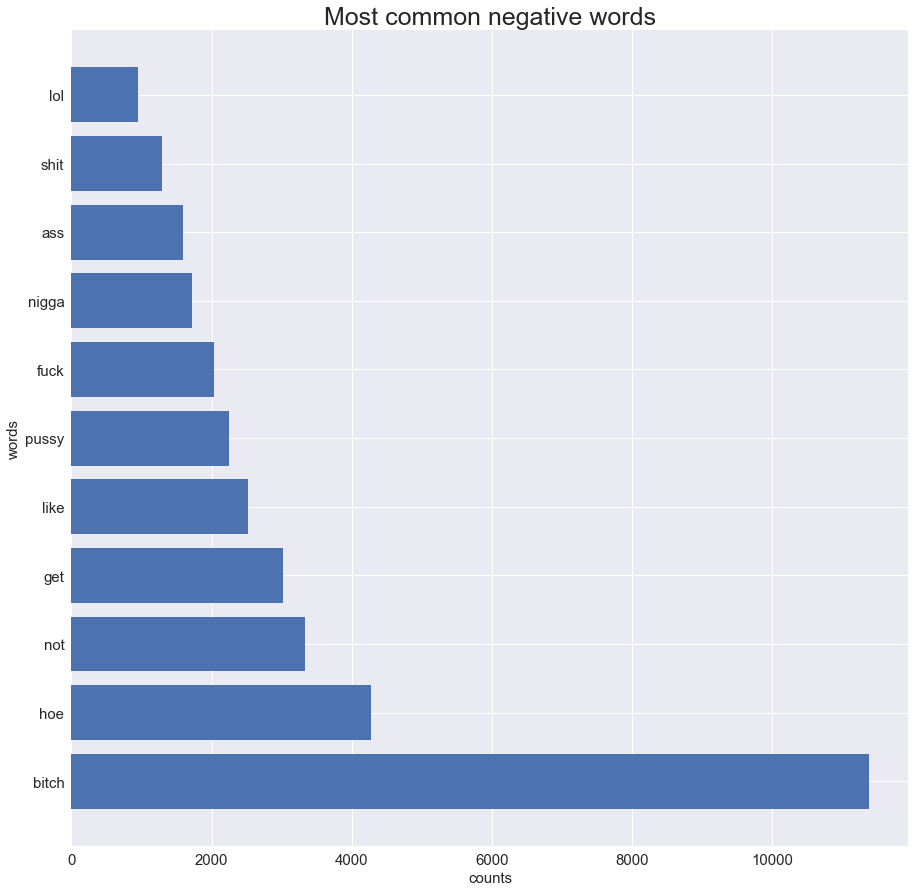

In [973]:
top_10_neg = tokens_neg[:11]

fig, ax = plt.subplots(figsize = (15,15))

plt.style.use('seaborn')
ax.barh(top_10_neg['token'], top_10_neg['token_count'])
plt.xlabel('counts', fontsize=15)
plt.ylabel('words',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Most common negative words', fontsize=25)

#fig.savefig('yourfilename.png')

## WordCloud Negative words (both ashtags and standard lexicon)

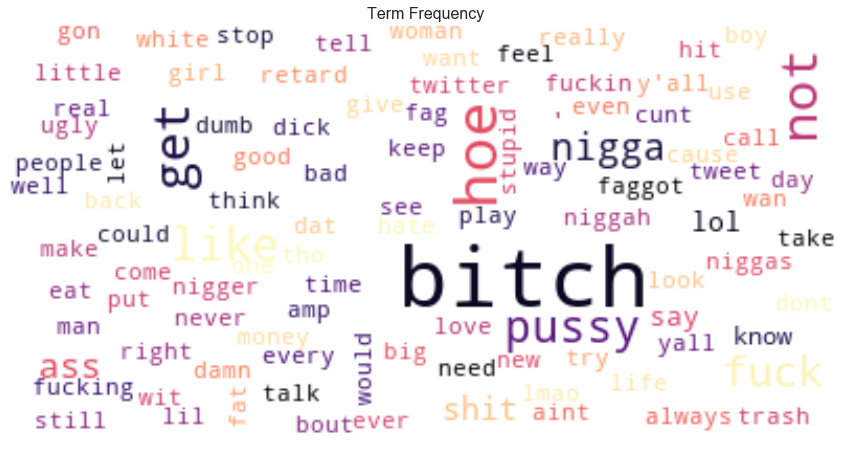

In [974]:
plot_word_cloud(tokens_neg,100)

# Length and Profanity


Most of the positive tweets seem to have in between 40 and 80 characters.

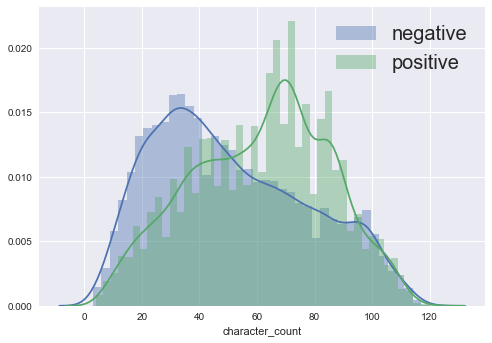

In [975]:
sns.distplot(df_neg['character_count'], label='negative')
sns.distplot(df_pos['character_count'], label='positive')
plt.legend(fontsize = 20)
plt.show()

Negative comments seem to be on average way shorter than their positive counterparts. This could also be due to the fact that offensive tweets use more emojis or alternative ways of communication. However, pure characters in terms of text are significantly less amongts negative comments.

In [976]:
pos_mean = df_pos['character_count'].mean()
pos_mean

61.182387878221014

In [977]:
pos_std = df_pos['character_count'].std()
pos_std

23.941652532716496

In [978]:
neg_mean = df_neg['character_count'].mean()
neg_mean

51.212965209374545

In [979]:
neg_std = df_neg['character_count'].std()
neg_std

26.730124000837616

Taking all the Tweets within one standard deviation of both negative and positive ones

In [980]:
df_length = df.loc[(df['character_count']> 30) &(df['character_count']<80)]
df_length['pos_label'].value_counts()

1    13554
0    11403
Name: pos_label, dtype: int64

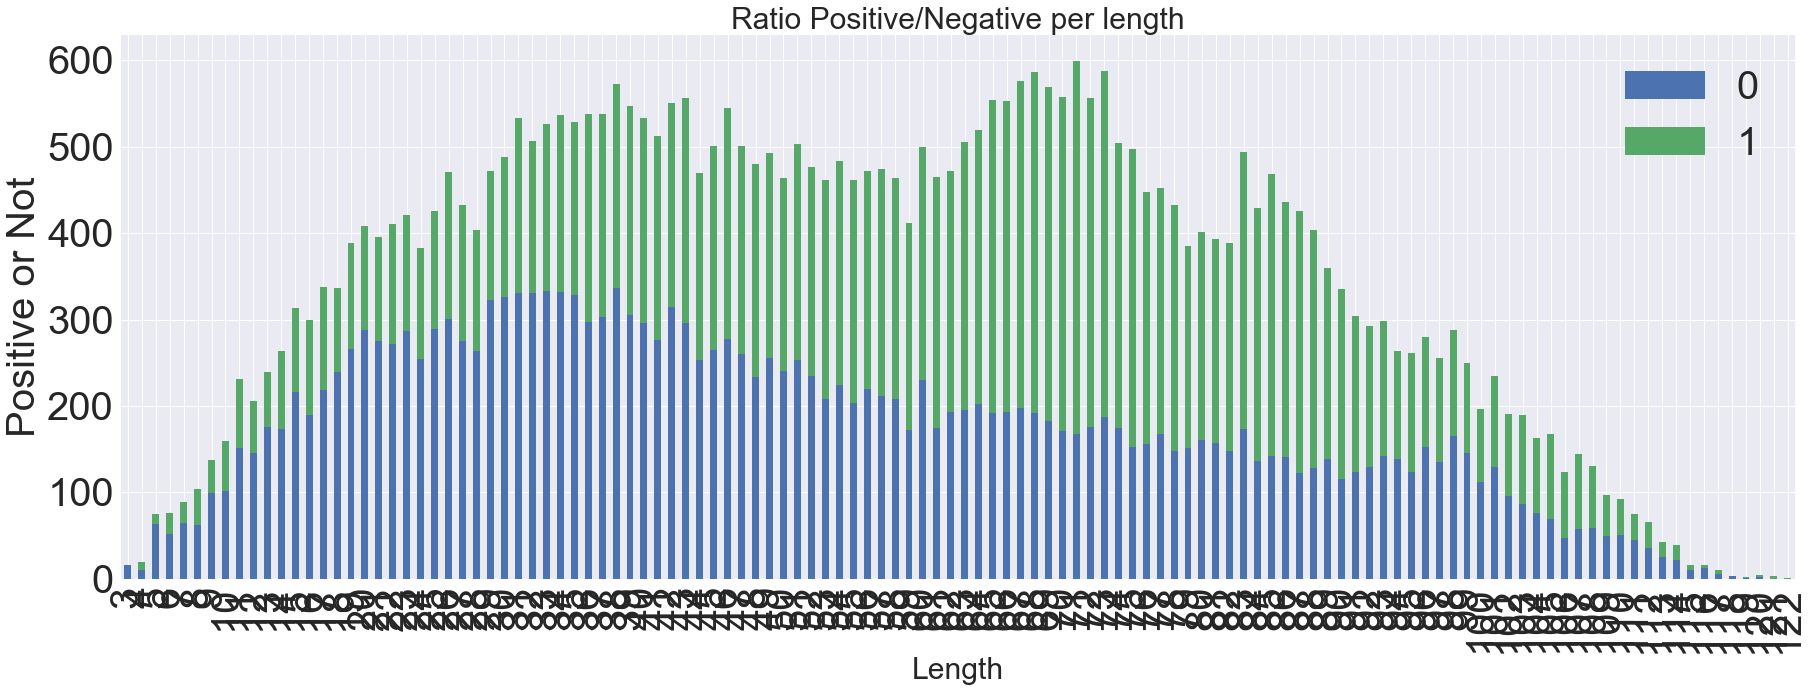

In [981]:
positive_grouped = df.groupby(["character_count", "pos_label"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))
plt.style.use('seaborn')
plt.xlabel("Length", fontsize = 30)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
plt.ylabel("Positive or Not", fontsize = 40)
plt.legend (loc = 1, fontsize = 40)
plt.title ('Ratio Positive/Negative per length', fontsize = 30)
plt.show()

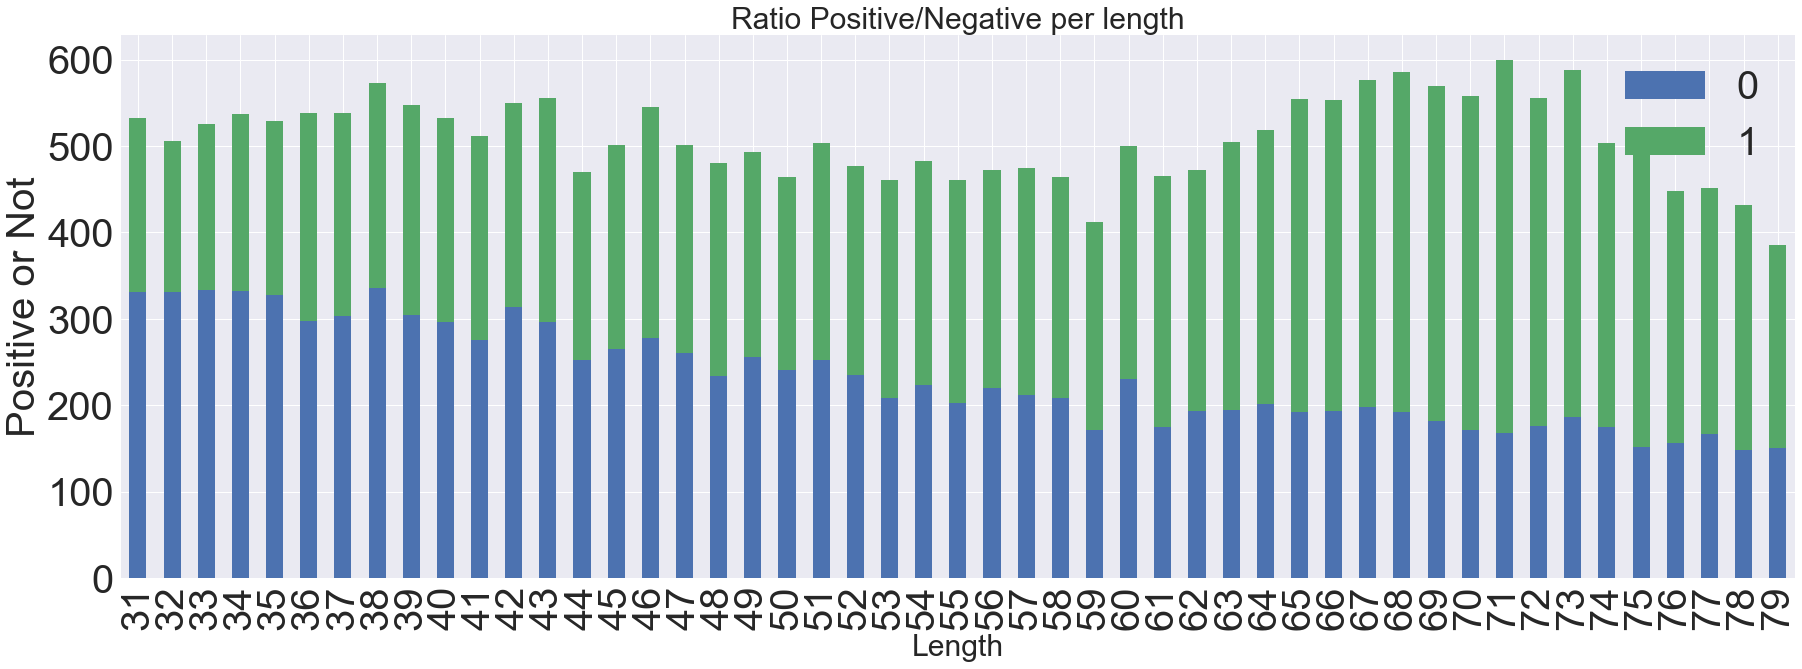

In [982]:
positive_grouped = df_length.groupby(["character_count", "pos_label"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))
plt.style.use('seaborn')
plt.xlabel("Length", fontsize = 30)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
plt.ylabel("Positive or Not", fontsize = 40)
plt.legend (loc = 1, fontsize = 40)
plt.title ('Ratio Positive/Negative per length', fontsize = 30)
plt.show()

## Is there a statistically significant difference between the two?

It is reasonable to assume that the variance of the two groups is similar, so we'll use a simple t-test in this case (and not Welch).

In [1008]:
t , p = stats.ttest_ind(df_pos['character_count'], 
                df_neg['character_count'],
                equal_var=True
               )

print(f't-critical value is {t}')
print(f'P-value is {p}')

t-critical value is 40.28992186454786
P-value is 0.0


Yes, very very strong!

# Number of Twitter handles and offensive language

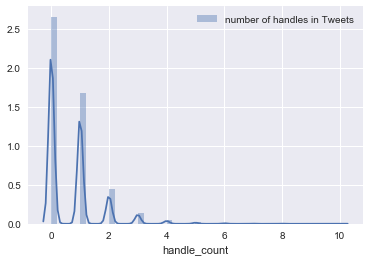

In [1002]:
sns.distplot(df['handle_count'], label = 'number of handles in Tweets')
plt.legend()
plt.show()

In [1003]:
df['handle_count'].value_counts()

0     22334
1     14067
2     3728 
3     1210 
4     375  
5     146  
6     74   
7     24   
8     22   
9     10   
10    2    
Name: handle_count, dtype: int64

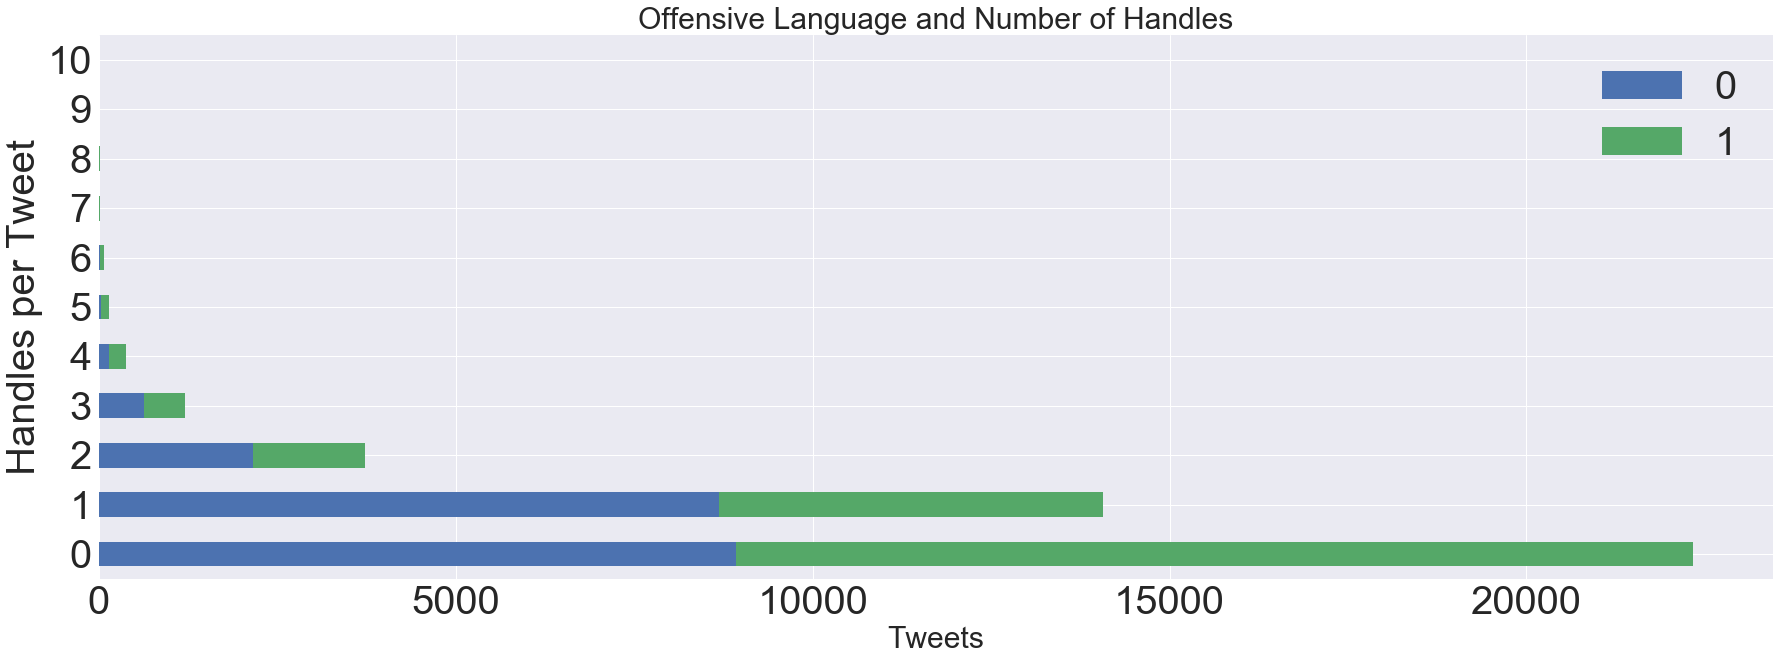

In [1006]:
positive_grouped = df.groupby(["handle_count", "pos_label"]).size().unstack().plot(kind='barh', stacked=True, figsize=(30,10))
plt.style.use('seaborn')
plt.xlabel("Tweets", fontsize = 30)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
plt.ylabel("Handles per Tweet", fontsize = 40)
plt.legend (loc = 1, fontsize = 40)
plt.title ('Offensive Language and Number of Handles', fontsize = 30)
plt.show()